In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train_dir = '/kaggle/input/dataset-food-classification/dataset_gambar/train'
validation_dir = '/kaggle/input/dataset-food-classification/dataset_gambar/valid'
testing_dir =  '/kaggle/input/dataset-food-classification/dataset_gambar/test'

In [5]:
train_batch_size = 20
val_batch_size = 10

train_images = train_generator.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=train_batch_size,
    shuffle=True,
    seed=42,
)

valid_images = train_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=val_batch_size,
    shuffle=True,
    seed=42,
)

test_images = test_generator.flow_from_directory(
    directory=testing_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=20,
    shuffle=False
)

Found 5193 images belonging to 13 classes.
Found 650 images belonging to 13 classes.
Found 648 images belonging to 13 classes.


In [6]:
# Input transfer learning model using Efficient Net B0
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Adding more layer in top of based model for fine tuning
inputs = pretrained_model.input

x = tf.keras.layers.Flatten()(pretrained_model.output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(13, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,176,240 (15.93 MB)

 Trainable params: 126,669 (494.80 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

None


In [8]:
# Training process

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=valid_images,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733068624.167436      85 service.cc:145] XLA service 0x7a63e8001e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733068624.167512      85 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/260 ━━━━━━━━━━━━━━━━━━━━ 2:25:06 34s/step - accuracy: 0.1000 - loss: 2.6136

I0000 00:00:1733068644.355700      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 ━━━━━━━━━━━━━━━━━━━━ 176s 550ms/step - accuracy: 0.2327 - loss: 2.4025 - val_accuracy: 0.6831 - val_loss: 1.2523
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 100s 376ms/step - accuracy: 0.6849 - loss: 1.0921 - val_accuracy: 0.8015 - val_loss: 0.6888
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 102s 382ms/step - accuracy: 0.7916 - loss: 0.6642 - val_accuracy: 0.8308 - val_loss: 0.5696
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 100s 377ms/step - accuracy: 0.8230 - loss: 0.5561 - val_accuracy: 0.8585 - val_loss: 0.4677
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 98s 366ms/step - accuracy: 0.8513 - loss: 0.4845 - val_accuracy: 0.8708 - val_loss: 0.4265
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 99s 369ms/step - accuracy: 0.8587 - loss: 0.4396 - val_accuracy: 0.8892 - val_loss: 0.3886
Epoch 7/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 100s 375ms/step - accuracy: 0.8711 - loss: 0.4276 - val_accuracy: 0.8831 - val_loss: 0.3984
Epoch 8/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 100s 374ms/step - accuracy: 0.8821 - loss: 0.3907

****Training Results****

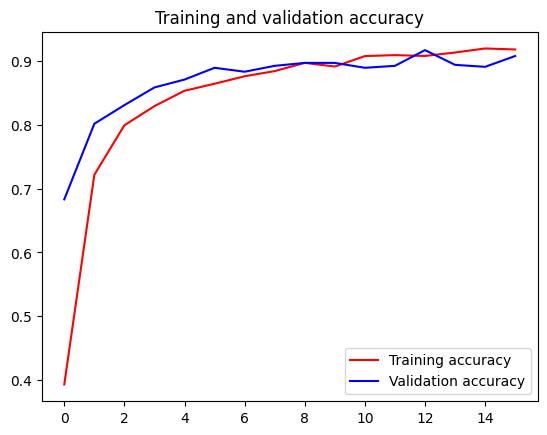

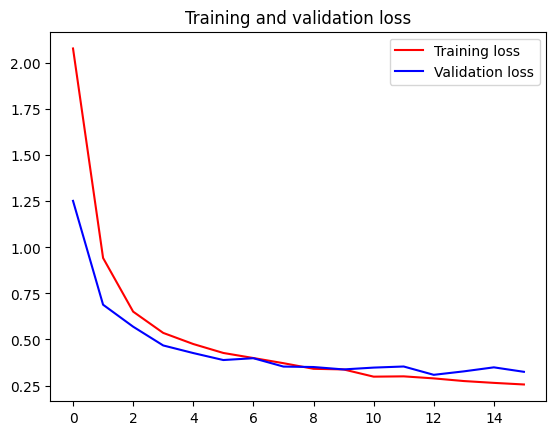

<Figure size 640x480 with 0 Axes>

In [9]:
# Plotting learning curve
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [10]:
# Assuming test_images is a tf.data.Dataset or numpy array
batch_size = 20
test_score = model.evaluate(test_images, batch_size=batch_size)

# Print results
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ", test_score[0])


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 515ms/step - accuracy: 0.9347 - loss: 0.2234
[INFO] accuracy: 91.67%
[INFO] Loss:  0.28430870175361633


In [11]:
y = np.concatenate([next(test_images)[1] for i in range(len(test_images))])
true_labels = np.argmax(y, axis=-1)

# Prediksi model
prediction = model.predict(test_images, verbose=2)
prediction = np.argmax(prediction, axis=-1)


33/33 - 20s - 604ms/step


In [12]:
# Plot to make confusion matrix
import numpy as np
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.96 0.   0.   0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.02]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.98 0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.  ]
 [0.   0.   0.   0.8  0.   0.06 0.   0.   0.   0.   0.02 0.02 0.1 ]
 [0.02 0.   0.   0.02 0.9  0.   0.   0.   0.   0.   0.02 0.02 0.02]
 [0.   0.   0.   0.02 0.   0.84 0.06 0.   0.   0.02 0.   0.   0.06]
 [0.02 0.   0.   0.   0.   0.   0.98 0.   0.   0.   0.   0.   0.  ]
 [0.04 0.   0.   0.02 0.06 0.02 0.04 0.8  0.   0.   0.02 0.   0.  ]
 [0.   0.   0.   0.02 0.   0.02 0.   0.   0.96 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.02 0.02 0.   0.92 0.   0.   0.04]
 [0.06 0.   0.   0.   0.02 0.   0.02 0.06 0.   0.04 0.8  0.   0.  ]
 [0.02 0.   0.   0.02 0.   0.   0.   0.   0.   0.02 0.02 0.92 0.  ]
 [0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.98]]


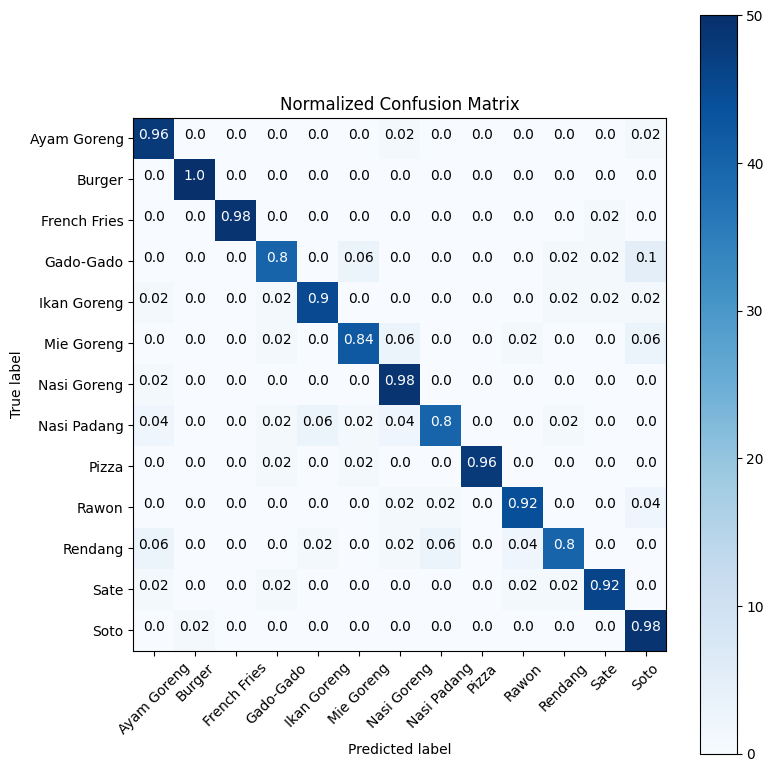

Accuracy: 0.910
Precision (Micro): 0.910
Recall (Micro): 0.910
F1-Score (Micro): 0.910


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Generate target names
target_names = list(train_images.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_labels, prediction)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm=cm, classes=target_names, normalize=True, title="Normalized Confusion Matrix")
plt.show()

# Accuracy
acc = accuracy_score(true_labels, prediction)
print(f"Accuracy: {acc:.3f}")

# Precision
precision = precision_score(true_labels, prediction, average='micro')
print(f"Precision (Micro): {precision:.3f}")

# Recall
recall = recall_score(true_labels, prediction, average='micro')
print(f"Recall (Micro): {recall:.3f}")

# F1 Score
f1 = f1_score(true_labels, prediction, average='micro')
print(f"F1-Score (Micro): {f1:.3f}")


In [14]:
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_all_classes(testing_dir, model, batch_size=20):
    # Ambil nama kelas dari folder dalam test_dir
    class_names = sorted(os.listdir(testing_dir))

    accuracies = [] 
    class_labels = [] 
    
    # Loop over each class in the test directory
    for class_name in class_names:
        class_dir = os.path.join(testing_dir, class_name)
        if not os.path.isdir(class_dir):  
            continue

        total_images = len(os.listdir(class_dir))
        correct_predictions = 0

        # Predict each image in the class directory
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            
            # Preprocess the image
            img_ = load_img(img_path, target_size=(224, 224))  # Resize to model input size
            img_array = img_to_array(img_)
            img_processed = preprocess_input(np.expand_dims(img_array, axis=0))  # Normalize using EfficientNet
            
            # Prediction
            prediction = model.predict(img_processed, verbose=0)
            index = np.argmax(prediction)  # Get the index of the highest prediction score
            predicted_label = class_names[index]  # Get predicted class label
            
            if predicted_label == class_name:  # Compare with true class
                correct_predictions += 1

        # Calculate accuracy for each class
        acc = correct_predictions / total_images
        accuracies.append(acc)
        class_labels.append(class_name)
        print(f"Class: {class_name}, Accuracy: {acc:.2f} ({correct_predictions}/{total_images})")

    # Plot accuracy per class
    plt.figure(figsize=(10, 6))
    bars = plt.barh(class_labels, accuracies, color='skyblue')
    plt.xlabel('Accuracy')
    plt.ylabel('Class')
    plt.title('Accuracy per Class')
    plt.xlim(0, 1)  # Set x-axis limit from 0 to 1 for accuracy
    
    # Annotate the bars with the accuracy value
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, f"{acc:.2f}",
                 va='center', ha='left', fontsize=10)
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

Class: Ayam Goreng, Accuracy: 0.98 (49/50)
Class: Burger, Accuracy: 1.00 (50/50)
Class: French Fries, Accuracy: 1.00 (50/50)
Class: Gado-Gado, Accuracy: 0.94 (47/50)
Class: Ikan Goreng, Accuracy: 0.92 (46/50)
Class: Mie Goreng, Accuracy: 0.92 (46/50)
Class: Nasi Goreng, Accuracy: 0.90 (45/50)
Class: Nasi Padang, Accuracy: 0.82 (41/50)
Class: Pizza, Accuracy: 1.00 (50/50)
Class: Rawon, Accuracy: 0.94 (47/50)
Class: Rendang, Accuracy: 0.88 (44/50)
Class: Sate, Accuracy: 0.96 (48/50)
Class: Soto, Accuracy: 0.94 (47/50)


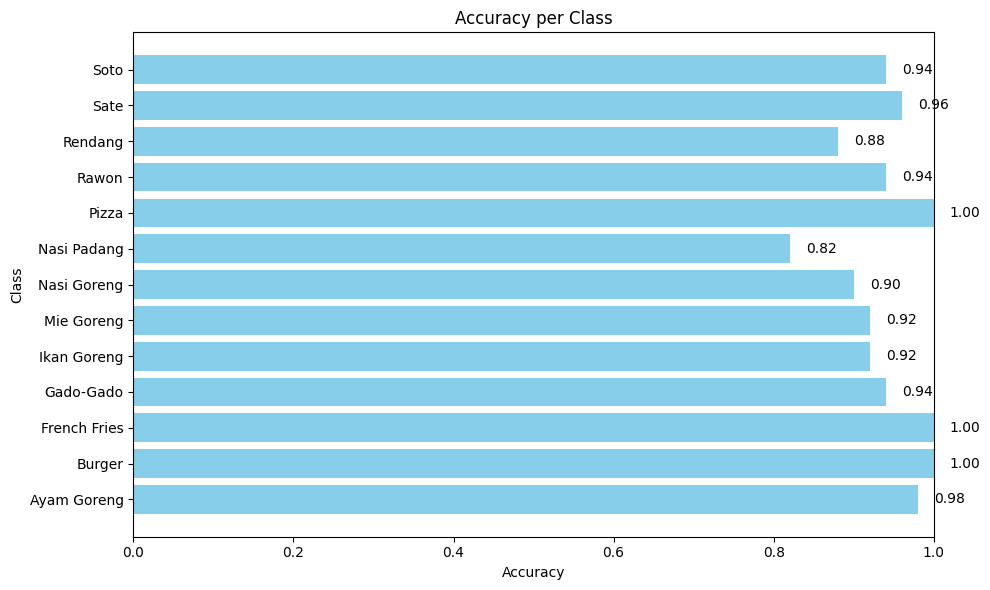

In [15]:
# Call the function with test dataset
predict_all_classes(testing_dir=testing_dir, model=model, batch_size=20)

In [1]:

def detect_allergens(food_class):
    """
    Detects allergens for a given food class and prints the result.
    """
    food_class = food_class.strip().title()  # Normalize input (remove spaces, capitalize words)
    
    if food_class in allergen_dict:
        allergens = allergen_dict[food_class]
        if allergens == ["None"]:
            print(f"✅ {food_class} contains no common allergens.")
        else:
            print(f"⚠️ {food_class} contains the following allergens: {', '.join(Allergens)}")
    else:
        print(f"❌ Error: Food class '{food_class}' not found in allergen dictionary.")

# Ask user for input
user_food = input("Enter a food item: ")
detect_allergens(user_food)


⚠️ Burger contains the following allergens: Gluten, Dairy, Soy
